In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.analysis.analysis_roc as ar

setGPU: Setting GPU to: 0


In [2]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [5]:
#Data Samples
#DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

#TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
#filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
#batch_size = 128
#train_set_size = int((5*10e5//batch_size)*batch_size)
#_,_, particles_bg = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)

In [3]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/'
filename_bg = DATA_PATH + 'QCD_training_data_02_08_2021.h5'
inFile = h5py.File(filename_bg, 'r')
particles_bg = inFile['particle_bg'][0:int(5*10e4)]
particles_bg_valid = inFile['particle_bg_valid'][0:int(1*10e4)]
particles_bg_test = inFile['particle_bg_test'][0:int(1*10e4)]
nodes_n = particles_bg.shape[1]
feat_sz = particles_bg.shape[2]

In [10]:
#signal
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

res_width = 'BROAD,NARROW'.split(',')
res_mass = '1.5,3.5'.split(',')
particles_sig_dict = {}

for width in res_width:
    for mass in res_mass:  
        SIG_NAME = 'RSGraviton_WW_'+width+'_13TeV_PU40_'+mass+'TeV_NEW'
        filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
        _,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)
        particles_sig_dict['Graviton '+width+' '+mass] = particles_sig
signal_types = list(particles_sig_dict.keys())        

Number of jets = 9890
Number of constituents (nodes) = 50
Number of features = 3
Number of jets = 9969
Number of constituents (nodes) = 50
Number of features = 3
Number of jets = 9854
Number of constituents (nodes) = 50
Number of features = 3
Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


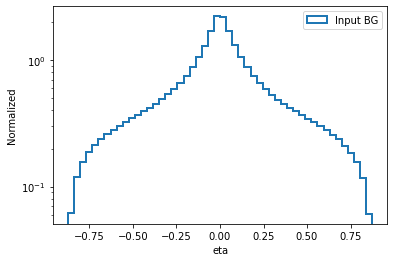

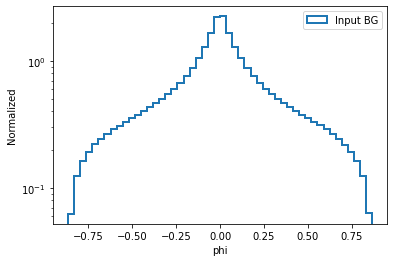

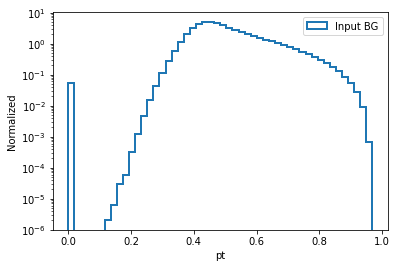

In [12]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

In [13]:
import tensorflow.keras.layers as klayers
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import models.layers as layers
reload(layers)
import models.custom_functions as funcs
reload(funcs)
import models.ParticleNetAE as pnae
reload(pnae)

<module 'models.ParticleNetAE' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/ParticleNetAE.py'>

# Particle Net AE

In [14]:
class _DotDict:
    pass

setting = _DotDict()
 # conv_params: list of tuple in the format (K, (C1, C2, C3))
setting.conv_params = [
 #       (7, (8, 12, 18)),
 #       (20, (25, 40, 64)),
 #       (30, (64,70, 70)),
        (7, (32, 32, 32)),
        (7, (64, 64, 64)),
        ]
#setting.conv_params_decoder = [60,32,16,8, 5]
setting.conv_params_decoder = [32,16,8]
# conv_pooling: 'average' or 'max'
setting.conv_pooling = 'average'
setting.conv_linking = 'concat' #concat or sum
setting.num_points = nodes_n #num of original consituents
setting.num_features = feat_sz #num of original features
setting.input_shapes = {'points': [nodes_n,feat_sz-1],'features':[nodes_n,feat_sz]}
setting.latent_dim = 10
setting.ae_type = 'vae'  #ae or vae 
setting.beta_kl = 10
setting.kl_warmup_time = 0
setting.activation = klayers.LeakyReLU(alpha=0.3)


In [126]:
model = pnae.PNVAE(setting=setting,name='PN_AE_')


Model: "ParticleNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_88 (Tenso [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_205 (Ten [(None, 50, 1, 3)]   0           features[0][0]                   
____________________________________________________________________________________

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128)]             0         
_________________________________________________________________
SamplingLayer (Functional)   [(None, 10), (None, 10),  2580      
Total params: 2,580
Trainable params: 2,580
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1600)              17600     
_________________________________________________________________
PN_AE__dense_0 (BatchNormali (None, 1600)              6400      
________________________________________

In [127]:
optim = Adam(learning_rate=0.001)

model.compile(optimizer=optim)

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

kl_beta_callback = models.KLWarmupCallback()   


history = model.fit((particles_bg[:50000,:,0:2], particles_bg[:50000,:,:]) ,  particles_bg[:50000,:,:],
                    validation_data = ((particles_bg_valid[:50000,:,0:2], particles_bg_valid[:50000,:,:]) , particles_bg_valid[:50000,:,:]),
                    epochs=5, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls,kl_beta_callback])

Epoch 1/5
391/391 [==============================] - 14s 36ms/step - loss: 0.0930 - reco_loss: 0.0915 - kl_loss: 1.5357e-04 - val_loss: 0.0411 - val_loss_reco: 0.0411 - val_loss_latent: 2.4833e-06
Epoch 2/5
391/391 [==============================] - 13s 34ms/step - loss: 0.0387 - reco_loss: 0.0387 - kl_loss: 1.7047e-06 - val_loss: 0.0350 - val_loss_reco: 0.0350 - val_loss_latent: 1.1615e-06
Epoch 3/5
391/391 [==============================] - 13s 34ms/step - loss: 0.0349 - reco_loss: 0.0349 - kl_loss: 8.9997e-07 - val_loss: 0.0333 - val_loss_reco: 0.0333 - val_loss_latent: 6.7577e-07
Epoch 4/5
391/391 [==============================] - 13s 34ms/step - loss: 0.0341 - reco_loss: 0.0340 - kl_loss: 5.5635e-07 - val_loss: 0.0325 - val_loss_reco: 0.0325 - val_loss_latent: 4.5523e-07
Epoch 5/5
391/391 [==============================] - 13s 34ms/step - loss: 0.0338 - reco_loss: 0.0338 - kl_loss: 3.9029e-07 - val_loss: 0.0327 - val_loss_reco: 0.0327 - val_loss_latent: 2.9244e-07


In [71]:
models_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/'
model_path = models_dir + "output_model_saved_PN_AE_2021_08_02_T_15_52"
#"output_model_saved_PN_VAE_2021_08_02_T_13_31"
#"output_model_saved_PN_AE_2021_08_02_T_15_52"
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={"PN_AE": pnae.PNVAE, "threeD_loss":losses.threeD_loss}
)
weights_path = models_dir + "PN_AE_weights_2021_08_02_T_15_52.18-0.022.hdf5"
#"PN_VAE_weights_2021_08_02_T_13_31.04-0.033.hdf5"
#'PN_AE_weights_2021_08_02_T_15_52.12-0.022.hdf5'
loaded_model.load_weights(
    weights_path, by_name=True, skip_mismatch=False)

In [72]:
model = loaded_model
particles_sig_dict['predicted'] = {}
latent_space_bg,Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
for sig in signal_types:
    latent_space_sig,Y_sig_predict = model.predict([particles_sig_dict[sig][:,:,0:2],particles_sig_dict[sig]])
    particles_sig_dict['predicted'][sig] = {}
    particles_sig_dict['predicted'][sig]['latent_space'] = latent_space_sig
    particles_sig_dict['predicted'][sig]['Y_sig_predict'] = Y_sig_predict

In [98]:
#import copy
#sig_out_of_phase_space = copy.deepcopy(particles_sig)
#sig_out_of_phase_space[:,:,2] = sig_out_of_phase_space[:,:,2] +0.5
#_,Y_sig_out_of_phase_space_predict = model.predict([sig_out_of_phase_space[:,:,0:2],sig_out_of_phase_space])

In [73]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)
particles_sig_dict['loss'] = {}
for sig in signal_types:
    particles_sig_dict['loss'][sig] = losses.threeD_loss_manual(particles_sig_dict[sig],particles_sig_dict['predicted'][sig]['Y_sig_predict'])

#loss_bg = losses.mse_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.mse_loss_manual(particles_sig,Y_sig_predict)



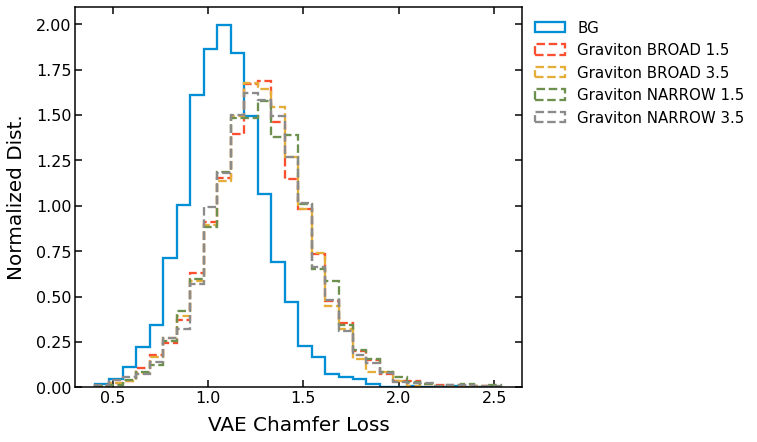

In [74]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = 1.1*np.max(loss_bg)
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2.3)
for sig in signal_types:
    plt.hist(particles_sig_dict['loss'][sig], bins=bins, label=sig, density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=2.3)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_loss_pn_ae.pdf'
plt.savefig(savename)
plt.show()

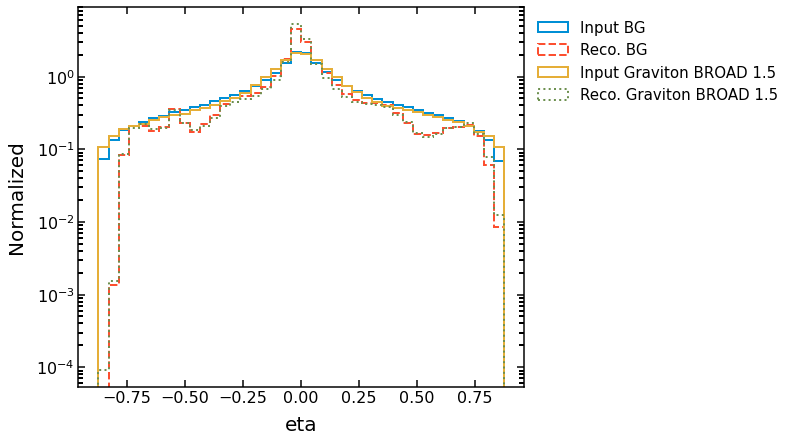

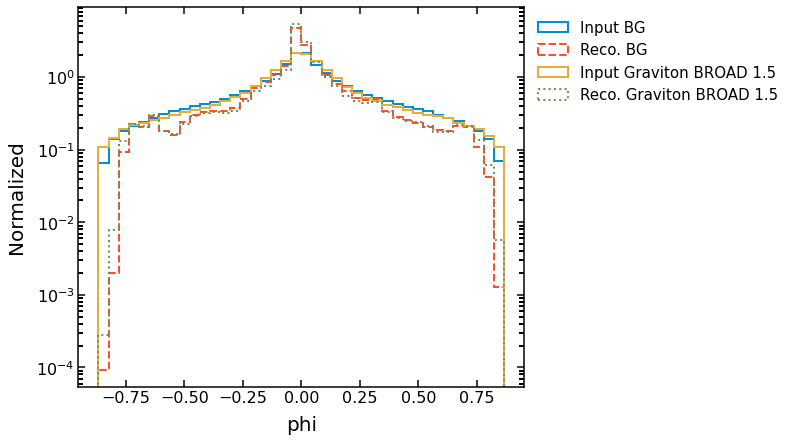

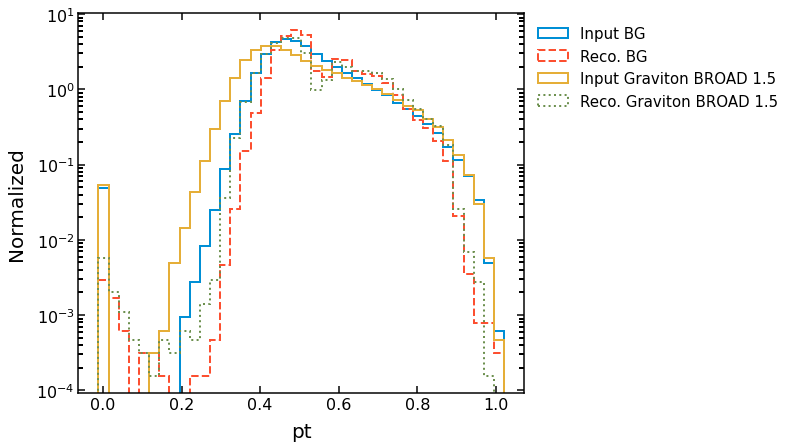

In [75]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    for sig in signal_types[0:1]:       
        _,_,_ = plt.hist(particles_sig_dict[sig][:,:,i].flatten(), bins=bins, label='Input '+sig,density=True, histtype='step', fill=False, linewidth=2)
        _,_,_ = plt.hist(particles_sig_dict['predicted'][sig]['Y_sig_predict'][:,:,i].flatten(), bins=bins, label='Reco. '+sig, linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_vars_pn_ae_{}.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


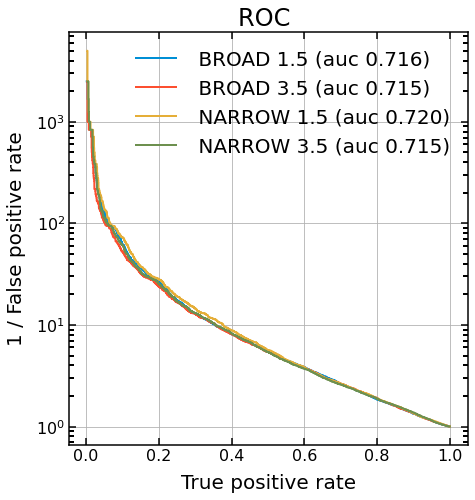

[0.7157423, 0.71499742, 0.72039724, 0.71518712]

In [76]:
neg_class_losses = [loss_bg.tolist()]*len(signal_types)
pos_class_losses = []
for sig in signal_types:
    pos_class_losses.append(particles_sig_dict['loss'][sig])

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=[sig.replace('Graviton','') for sig in signal_types], title='ROC ',
            plot_name='ROC_pn_ae_signals', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [116]:
len(latent_space_sig)

3

In [19]:
#dataset= tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2], particles_bg))


In [20]:
import plotly.express as px
import plotly.graph_objects as go

In [120]:
fig = go.Figure([
        go.Scatter3d(
            name='BG',
            x=latent_space_bg[0][:,0],
            y=latent_space_bg[1][:,1],
            z=latent_space_bg[2][:,2],
            mode='markers', opacity=0.3,
            hovertemplate
            ="x: %{x:0.2f}<br>y: %{z:0.2f}<br>z: %{y:0.2f}<br>",
            showlegend=True
            ),
        go.Scatter3d(
            name='SIG',
            x=latent_space_sig[0][:,0],
            y=latent_space_sig[1][:,1],
            z=latent_space_sig[2][:,2],
            mode='markers', opacity=0.3,
            hovertemplate
            ="x: %{x:0.2f}<br>y: %{z:0.2f}<br>z: %{y:0.2f}<br>",
            showlegend=True
            ),
    ]
    )
fig.show()